In [1]:
from __future__ import print_function
from kipet.library.TemplateBuilder import *
from kipet.library.PyomoSimulator import *
from kipet.library.ParameterEstimator import *
from kipet.library.VarianceEstimator import *
from kipet.library.data_tools import *
import matplotlib.pyplot as plt
import os
import sys
import inspect
import six
import pandas as pd
from scipy.stats import t

In [2]:
flow_df = pd.read_csv('../my_data_sets/flow.dat', delimiter=r"\s+", header = None)
flow_df.columns = ['time', 'Qf', 'x']
flow_df['Qf'] = flow_df['Qf'] / 0.728
flow_df = flow_df.set_index('time')

In [3]:
flow_df

,Qf,x
time,,
9.0,0.134365,4.7860
19.0,1.772804,14.2180
29.0,1.734587,13.9980
39.0,1.703319,13.8180
49.0,1.669967,13.6260
...,...,...
829.0,0.000990,4.0182
839.0,0.000782,4.0170
849.0,0.000643,4.0162


In [4]:
lc_data = pd.read_csv('../my_data_sets/lc.dat', delimiter=r"\s+", header = None)
lc_data.columns = ['time', 'y']
lc_data = lc_data.set_index('time')

In [5]:
lc_data

,y
time,
414,0.1705
424,0.1604
434,0.1325
444,0.1084
493,0.1014
503,0.1042
513,0.1045
523,0.0970
533,0.0824


In [21]:
builder = TemplateBuilder()    
components = {'A':2.35,'B':0,'C':0, 'D':0, 'V': 2370, 'y': 0}
builder.add_mixture_component(components)

builder.add_parameter('k1',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('k2',initialize = 100, bounds=(0.0,5e3))
builder.add_parameter('na0', init = 2.35, bounds = (0, 10))

builder.add_algebraic_variable('qin_B')
#builder.add_algebraic_variable('y')
builder.add_concentration_data(lc_data)

cbf = 0.00721

In [40]:
def rule_odes(m,t):
    exprs = dict()
    exprs['A'] = -m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] / m.Z[t, 'V']
    exprs['B'] = m.Y[t, 'qin_B'] * cbf - (m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] + m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'])/m.Z[t, 'V']
    exprs['C'] = (m.P['k1'] * m.Z[t, 'A'] * m.Z[t, 'B'] - m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'])/m.Z[t, 'V']
    exprs['D'] = m.P['k2'] * m.Z[t, 'B'] * m.Z[t, 'C'] / m.Z[t, 'V']
    exprs['V'] = m.Y[t, 'qin_B']
    exprs['y'] = exprs['C'] / (m.Z[t, 'C'] + 2 * m.Z[t, 'D'] + 1.0e-5) - (m.Z[t, 'C'] / (m.Z[t, 'C'] + 2 * m.Z[t, 'D'] + 1.0e-5) **2) *(exprs['C'] + 2 * exprs['D'])
    return exprs

builder.set_odes_rule(rule_odes)
    

In [23]:
def rule_algebraics(m, t):
    r = list()
    r.append(m.Y[t, 'y'] * (m.Z[t, 'C'] + 2 * m.Z[t, 'D']) - m.Z[t, 'C'])
    return r

builder.set_algebraics_rule(rule_algebraics)

In [41]:
model = builder.create_pyomo_model(0, 900)

 If this is the desired behavior, some odes must be added after the model is created.
 If this is the desired behavior, some algebraics must be added after the model is created.


In [42]:
# explicitly add constraints for initial conditions and relax the auto-imposed initial conditions by builder
model.ca0_cons = Constraint(expr = model.Z[0, 'A'] == model.P['na0'])
model.init_conditions_c['A'].deactivate()

In [43]:
p_estimator = ParameterEstimator(model)

In [44]:
qinB_row0 = pd.DataFrame({'time':[0], 'qin_B':[0]}).set_index('time')
qinB_row0

,qin_B
time,
0,0


In [45]:
qinB_traj = flow_df[['Qf']]
qinB_traj.columns = ['qin_B']
qinB_traj = qinB_traj.append(qinB_row0).sort_index()
qinB_traj.head()

,qin_B
time,
0.0,0.000000
9.0,0.134365
19.0,1.772804
29.0,1.734587
39.0,1.703319


In [46]:
inputs_sub = {}
inputs_sub['Y'] = ['qin_B']

In [47]:
p_estimator.apply_discretization('dae.collocation',nfe=60,ncp=3,scheme='LAGRANGE-RADAU')
p_estimator.fix_from_trajectory('Y', 'qin_B', qinB_traj) 

[(0, 0.0),
 (2.005973, 0.029948098587663924),
 (8.344027, 0.124571837813435),
 (12.9375, 0.7795002857657969),
 (14.943473, 1.1081666068958278),
 (21.281527, 1.7640842521711542),
 (25.875, 1.7465293612637365),
 (27.880973, 1.7388631276365387),
 (34.219027, 1.7182677593954672),
 (38.8125, 1.7039049536401099),
 (40.818473, 1.6972537741153848),
 (47.156527, 1.676115319291209),
 (51.75, 1.6591710164835167),
 (53.755973, 1.651295919184066),
 (60.094027, 1.626717846835302),
 (64.6875, 1.609961134958791),
 (66.693473, 1.6026434666949174),
 (73.031527, 1.258636393759849),
 (77.625, 0.8762657949862637),
 (79.630973, 0.8099032178954255),
 (85.969027, 1.2930160733133649),
 (90.5625, 1.5782254893543954),
 (92.568473, 1.6477779188517856),
 (98.906527, 1.8675351409009617),
 (103.5, 1.8524843406593408),
 (105.505973, 1.8443303910692308),
 (111.844027, 1.8154056102342033),
 (116.4375, 1.791627446771978),
 (118.443473, 1.7812435054938187),
 (124.781527, 1.7602850413322801),
 (129.375, 1.7456877060439562

In [48]:
nt = len(p_estimator.model.alltime.value)
t_list = np.zeros(nt)
qin_B_list = np.zeros(nt)
for (i, t) in enumerate(sorted(p_estimator.model.alltime.value)):
    t_list[i] = t
    qin_B_list[i] = p_estimator.model.Y[t, 'qin_B']()

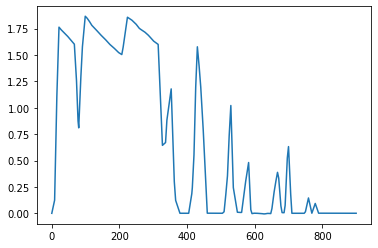

In [49]:
fig, ax = plt.subplots()
ax.plot(t_list, qin_B_list)

In [50]:
sigmas = {'A':1, 'B':1, 'C':1, 'D':1, 'V':1, 'y':1}

# Again we provide options for the solver, this time providing the scaling that we set above
options = dict()
#options['nlp_scaling_method'] = 'user-scaling'
options['linear_solver'] = 'ma27'
# finally we run the optimization
results_pyomo = p_estimator.run_opt('ipopt',
                                        variances=sigmas,
                                      tee=True,
                                   solver_opts = options)

Ipopt 3.12: linear_solver=ma27


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     9549
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2522

Total number of variables............................:     1989
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1986
Total

  73  0.0000000e+00 1.45e+00 1.62e+09  -9.0 5.09e-01   5.5 1.00e+00 3.82e-01h  1
  74r 0.0000000e+00 1.45e+00 9.99e+02   0.2 0.00e+00   5.1 0.00e+00 1.36e-09R  2
  75r 0.0000000e+00 1.45e+00 9.99e+02   0.2 1.72e+08    -  7.68e-09 5.07e-09f  2
  76r 0.0000000e+00 2.05e-01 9.72e+02   0.2 1.44e+03    -  1.62e-01 9.93e-04f  1
  77  0.0000000e+00 5.92e-03 2.21e+05  -9.0 8.88e-02   4.6 1.00e+00 1.00e+00h  1
  78  0.0000000e+00 1.53e-03 9.49e+04  -9.0 1.44e-01   4.1 1.00e+00 6.25e-01h  1
  79r 0.0000000e+00 1.53e-03 9.99e+02  -2.8 0.00e+00   3.6 0.00e+00 1.48e-09R  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 0.0000000e+00 1.55e-03 9.99e+02  -2.8 3.21e+05    -  1.80e-07 7.93e-08f  1
  81r 0.0000000e+00 1.55e-03 1.00e+03  -2.8 4.28e+01    -  6.78e-03 3.50e-15f 39
  82r 0.0000000e+00 1.55e-03 1.00e+03  -2.8 1.61e+01    -  1.81e-01 6.78e-15h 41
  83r 0.0000000e+00 7.07e-04 8.96e+02  -2.8 1.55e+01    -  1.04e-01 1.04e-01s 54
  84r 0.0000000e+00 7.07e-04

 167r 0.0000000e+00 2.74e-05 9.99e+02  -4.6 0.00e+00    -  0.00e+00 4.77e-07R 22
 168r 0.0000000e+00 2.74e-05 9.98e+02  -4.6 2.55e+00    -  8.05e-02 1.05e-15f 42
 169r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 2.71e+00    -  5.08e-03 1.23e-14f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170r 0.0000000e+00 2.74e-05 9.98e+02  -4.6 3.01e+00    -  1.35e-01 1.20e-14f 43
 171r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.04e+00    -  1.31e-02 1.90e-14f 42
 172r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.26e+00    -  3.75e-02 3.32e-14f 41
 173r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.41e+00    -  2.47e-02 3.88e-14f 43
 174r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.54e+00    -  7.44e-02 3.90e-14f 42
 175r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.44e+00    -  6.15e-02 2.89e-14f 44
 176r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.51e+00    -  1.46e-01 4.07e-14f 43
 177r 0.0000000e+00 2.74e-05 1.00e+03  -4.6 3.47e+00    -  2.20e-01 4.41e-14f 44
 178r 0.0000000e+00 8.68e-06

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270r 0.0000000e+00 1.61e-06 9.99e+02  -5.8 0.00e+00    -  0.00e+00 4.77e-07R 22
 271r 0.0000000e+00 1.61e-06 1.00e+03  -5.8 8.24e-01    -  2.07e-02 9.88e-16f 42
 272r 0.0000000e+00 1.61e-06 1.00e+03  -5.8 9.99e-01    -  1.67e-02 6.37e-15f 42
 273r 0.0000000e+00 1.61e-06 9.83e+02  -5.8 1.01e+00    -  6.59e-01 6.31e-15f 43
 274r 0.0000000e+00 1.61e-06 1.00e+03  -5.8 1.01e+00    -  4.51e-02 1.06e-13f 41
 275r 0.0000000e+00 1.61e-06 8.49e+02  -5.8 1.12e+00    -  1.00e+00 1.22e-04f  9
 276r 0.0000000e+00 1.42e-06 7.36e+02  -5.8 1.06e+00    -  1.00e+00 1.19e-01f  4
 277r 0.0000000e+00 1.42e-06 9.99e+02  -5.8 0.00e+00    -  0.00e+00 4.77e-07R 22
 278r 0.0000000e+00 1.42e-06 1.00e+03  -5.8 7.68e-01    -  2.06e-02 9.86e-16f 42
 279r 0.0000000e+00 1.42e-06 1.00e+03  -5.8 9.34e-01    -  1.58e-02 3.16e-15f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 0.0000000e+00 1.42e-06

 368r 0.0000000e+00 2.68e-07 9.99e+02  -6.6 0.00e+00    -  0.00e+00 4.77e-07R 22
 369r 0.0000000e+00 2.68e-07 1.00e+03  -6.6 3.08e-01    -  1.90e-02 9.61e-16f 42
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370r 0.0000000e+00 2.68e-07 1.00e+03  -6.6 3.91e-01    -  9.77e-03 2.88e-15f 43
 371r 0.0000000e+00 2.68e-07 9.83e+02  -6.6 3.95e-01    -  6.66e-01 4.63e-15f 43
 372r 0.0000000e+00 2.68e-07 1.00e+03  -6.6 3.98e-01    -  5.42e-02 1.99e-13f 40
 373r 0.0000000e+00 2.68e-07 8.42e+02  -6.6 4.43e-01    -  1.00e+00 1.60e-11f 32
 374r 0.0000000e+00 2.36e-07 7.31e+02  -6.6 4.23e-01    -  1.00e+00 1.19e-01f  4
 375r 0.0000000e+00 2.36e-07 9.99e+02  -6.6 0.00e+00    -  0.00e+00 4.77e-07R 22
 376r 0.0000000e+00 2.36e-07 1.00e+03  -6.6 2.87e-01    -  1.89e-02 9.59e-16f 42
 377r 0.0000000e+00 2.36e-07 1.00e+03  -6.6 3.65e-01    -  9.51e-03 5.72e-15f 42
 378r 0.0000000e+00 2.36e-07 9.83e+02  -6.6 3.69e-01    -  6.67e-01 4.57e-15f 43
 379r 0.0000000e+00 2.36e-07

 466r 0.0000000e+00 4.43e-08 9.99e+02  -7.4 0.00e+00    -  0.00e+00 4.77e-07R 22
 467r 0.0000000e+00 4.43e-08 1.00e+03  -7.4 1.15e-01    -  1.80e-02 1.87e-15f 41
 468r 0.0000000e+00 4.43e-08 1.00e+03  -7.4 1.53e-01    -  7.38e-03 2.78e-15f 43
 469r 0.0000000e+00 4.43e-08 9.82e+02  -7.4 1.55e-01    -  6.69e-01 4.10e-15f 43
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r 0.0000000e+00 4.43e-08 1.00e+03  -7.4 1.57e-01    -  6.40e-02 3.75e-13f 39
 471r 0.0000000e+00 4.43e-08 8.35e+02  -7.4 1.76e-01    -  1.00e+00 2.20e-12f 35
 472r 0.0000000e+00 3.89e-08 7.25e+02  -7.4 1.68e-01    -  1.00e+00 1.19e-01f  4
 473r 0.0000000e+00 3.89e-08 9.99e+02  -7.4 0.00e+00    -  0.00e+00 4.77e-07R 22
 474r 0.0000000e+00 3.89e-08 1.00e+03  -7.4 1.07e-01    -  1.80e-02 1.87e-15f 41
 475r 0.0000000e+00 3.89e-08 1.00e+03  -7.4 1.43e-01    -  7.29e-03 5.57e-15f 42
 476r 0.0000000e+00 3.89e-08 9.82e+02  -7.4 1.45e-01    -  6.69e-01 8.20e-15f 42
 477r 0.0000000e+00 3.89e-08

In [51]:
print("The estimated parameters are:")
for k,v in six.iteritems(results_pyomo.P):
    print(k, v)

The estimated parameters are:
k1 2061.9237258927405
k2 2311.2300928139703
na0 5.708610520094235e-12


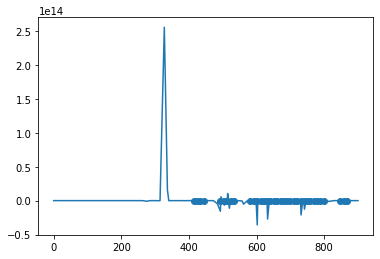

In [52]:
fig, ax = plt.subplots()
ax.scatter(lc_data.index, lc_data['y'])
ax.plot(results_pyomo.Y.index, results_pyomo.Y['y'])